# Required Packages
This notebook uses torch and numpy for neural networks and math and matplotlib, ipywidgets and IPython for displaying data

In [63]:
import torch
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import tensorboard

import datetime

import matplotlib.pyplot as plt
from ipywidgets import interactive
from IPython.display import display, clear_output

# Learned Functions
First There need to be some function for the neural network to approximate. Below are a few functions I added for the neural network to learn. Each has an interactive display to play around with the parameters if there are any parameters.

In [2]:
def calc_summed_sin(x, freq1, phase1, freq2, phase2):
    y_1 = np.sin(freq1*x+phase1)
    y_2 = np.sin(freq2*x+phase2)

    y_3 = (y_1 + y_2) * 0.5

    return y_3

def plot_summed_sin(freq1, phase1, freq2, phase2):
    x = np.linspace(-1, 1, 500)
    
    y = calc_summed_sin(x, freq1, phase1, freq2, phase2)
    
    fig, ax = plt.subplots()
    ax.plot(x, y)

    ax.set(xlim=(-1, 1), ylim=(-1, 1))
    
    plt.show()

interactive_summed_sin_wave = interactive(plot_summed_sin, freq1=(1, 6*np.pi), phase1=(0.0, 20.0), freq2=(1, 6*np.pi), phase2=(0.0, 20.0))
interactive_summed_sin_wave

interactive(children=(FloatSlider(value=9.92477796076938, description='freq1', max=18.84955592153876, min=1.0)…

In [3]:
def calc_cubed(x):
    return x * x * x

def plot_cubed():
    x = np.linspace(-1, 1, 500)
    
    y = calc_cubed(x)
    
    fig, ax = plt.subplots()
    ax.plot(x, y)

    ax.set(xlim=(-1, 1), ylim=(-1, 1))
    
    plt.show()

interactive_cubed = interactive(plot_cubed)
interactive_cubed

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [4]:
def calc_sin_exp_summed(x, freq1, exp1, freq2, phase2):
    y_1 = np.power(x * freq1, exp1)
    y_2 = np.sin(freq2*x+phase2)

    y_3 = (y_1 + y_2) * 0.5

    return y_3

def plot_sin_exp_summed(freq1, exp1, freq2, phase2):
    x = np.linspace(-1, 1, 500)
    
    y = calc_sin_exp_summed(x, freq1, exp1, freq2, phase2)
    
    fig, ax = plt.subplots()
    ax.plot(x, y)

    ax.set(xlim=(-1, 1), ylim=(-1, 1))
    
    plt.show()

interactive_sin_exp_summed = interactive(plot_sin_exp_summed, freq1=(1, 6*np.pi), exp1=(0, 8), freq2=(1, 6*np.pi), phase2=(0.0, 20.0))
interactive_sin_exp_summed

interactive(children=(FloatSlider(value=9.92477796076938, description='freq1', max=18.84955592153876, min=1.0)…

# Function Wrapper
To make it easier to try different functions I put the graphed functions above in a wrapper function that hard codes any parameters and just takes in the x value. This way the code for training the neural network doesn't have to change that much. Pick the cell with the function you want to train on, set the parameters using the above interactive graphs as reference, and then run the cell.

In [5]:
def function(x):
    freq1 = 7.4
    phase1 = 14.2
    freq2 = 14.1
    phase2 = 10.0

    return calc_summed_sin(x, freq1, phase1, freq2, phase2)

In [50]:
def function(x):
    freq1 = 1.8
    exp1 = 3
    freq2 = 12.0
    phase2 = 9.6

    return calc_sin_exp_summed(x, freq1, exp1, freq2, phase2)

In [ ]:
def function(x):
    return calc_cubed(x)

# Create Training and Testing Data
The below cell creates the training data for the neural network and displays it. The sample/training data is displayed as red 'x''s and the test data is displayed as a blue line. The number of samples and tests can be set with the variables at the top off the cell.

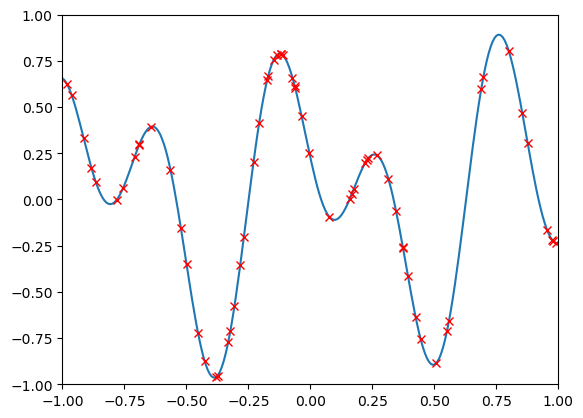

In [6]:
num_samples = 64
num_tests = 250

sample_inputs = (np.random.rand(num_samples) * 2.0) - 1.0
sample_outputs = function(sample_inputs)

test_inputs = np.linspace(-1, 1, num_tests)
test_outputs = function(test_inputs)

sample_inputs = np.float32(sample_inputs)
sample_outputs = np.float32(sample_outputs)
test_inputs = np.float32(test_inputs)
test_outputs = np.float32(test_outputs)
    
fig, ax = plt.subplots()
ax.plot(test_inputs, test_outputs)
ax.plot(sample_inputs, sample_outputs, 'xr')

ax.set(xlim=(-1, 1), ylim=(-1, 1))
    
plt.show()

# Defining Classes/Structures
The next two cells define the neural network class which has all the layers of the NN and a function to run the NN. The number of is decided when the network is created. The number of hidden layers and their size can be easily changed below. The next cell simply creates a structure that just holds the training data so it is easier to package and move around.

In [7]:
hidden_layer_size = 32
output_layer_size = 1

class NeuralNetwork(torch.nn.Module):
    def __init__(self, input_layer_size):
        super().__init__()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(input_layer_size, hidden_layer_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layer_size, hidden_layer_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layer_size, hidden_layer_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layer_size, output_layer_size),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [8]:
class TrainingData:
    def __init__(self):
        self.input_tensor_sample_batch = None
        self.output_tensor_sample_batch = None
        self.input_tensor_test_batch = None
        self.output_tensor_test_batch = None

# Training Functions
The below cell defines two functions, one for training the neural network and one for testing the neural network. The training function takes in all the required info including a batch of data and trains the network of the data multiple times and periodically prints out the progress. The test function takes in most of the same data and returns the predicted output and the loss. The next cell puts these two functions in a loop and displays the data on a graph.

In [44]:
def train(model, optimizer, loss_fn, input_tensor_batch, expected_output_tensor_batch, num_batches, epoch_index):
    batch_size = input_tensor_batch.shape[0]
    size = num_batches * batch_size
    
    model.train()

    for batch_index in range(0, num_batches):
        pred = model(input_tensor_batch)
        loss = loss_fn(pred, expected_output_tensor_batch)

        writer.add_scalar('loss', loss.item(), batch_index + epoch_index * num_batches)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 0:
            current = (batch_index + 1) * batch_size
            print(f"train loss: {loss.item():>7f} [{current:>5d}/{size:>5d}]")

    writer.flush()

def test(model, loss_fn, input_tensor_batch, expected_output_tensor_batch):
    model.eval()    

    with torch.no_grad():
        pred = model(input_tensor_batch)
        test_loss = loss_fn(pred, expected_output_tensor_batch).item()

    return pred, test_loss

In [83]:
def training_loop(model, data, loss_fn, optimizer, num_epochs, batches_per_epoch):
    for epoch_index in range(0, num_epochs + 1):
        clear_output(wait=True)

        fig, ax = plt.subplots()

        ax.plot(test_inputs, test_outputs, '--k')
    
        pred_outputs, test_loss = test(model, loss_fn, data.input_tensor_test_batch, data.output_tensor_test_batch)

        ax.plot(sample_inputs, sample_outputs, 'xr')
        ax.plot(test_inputs, pred_outputs.numpy())

        ax.set(xlim=(-1, 1), xticks=np.arange(-1, 1.2, 0.2),
               ylim=(-1, 1), yticks=np.arange(-1, 1.2, 0.2))

        plt.show()

        print(f"test loss: {test_loss:>7f}")
        
        writer.add_histogram("layer0/weights", model.linear_relu_stack[0].weight, epoch_index)
        writer.add_histogram("layer0/biases", model.linear_relu_stack[0].bias, epoch_index)
    
        if epoch_index < num_epochs:
            print(f"epoch: {epoch_index+1:>2d}")
            train(model, optimizer, loss_fn, data.input_tensor_sample_batch, data.output_tensor_sample_batch, batches_per_epoch, epoch_index)

# 1 Input Feature
Here I am creating a network with one input feature being the x value and converting the training data to tensors so they can be used to train. The second cell runs the training loop using the create network and data. Run the first cell to init or re-init the network. The second cell can be run multiple times to increase the accuracy of the network. The learning rate, batches per epoch and number of epoches can be changed at the top of the second cell.

In [70]:
input_layer_size = 1
regular_model = NeuralNetwork(input_layer_size)

regular_data = TrainingData()

regular_data.input_tensor_sample_batch = torch.from_numpy(np.reshape(sample_inputs, (-1, 1)))
regular_data.output_tensor_sample_batch = torch.from_numpy(np.reshape(sample_outputs, (-1, 1)))

regular_data.input_tensor_test_batch = torch.from_numpy(np.reshape(test_inputs, (-1, 1)))
regular_data.output_tensor_test_batch = torch.from_numpy(np.reshape(test_outputs, (-1, 1)))

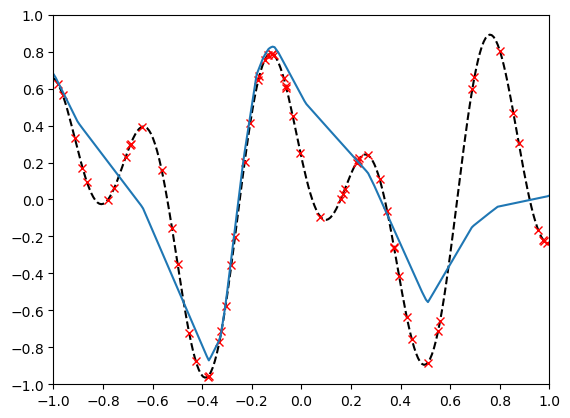

test loss: 0.259550


In [71]:
learning_rate = 0.01

batches_per_epoch = 1000
num_epochs = 10

loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.SGD(regular_model.parameters(), lr=learning_rate)

writer = SummaryWriter("../experiments/graph_function/regular/" + now.strftime("%Y%m%d-%H%M%S"))

training_loop(regular_model, regular_data, loss_fn, optimizer, num_epochs, batches_per_epoch)

writer.close()
del writer

# Taylor Series Features
These two cells are identical to the above cells but this network uses taylor series features to increase the learning rate of the network. The network should be noticables faster at learning the function. The number of taylor features can be changed at the top of the first cell.

In [72]:
num_taylor_features = 6
input_layer_size = num_taylor_features + 1
taylor_model = NeuralNetwork(input_layer_size)

taylor_data = TrainingData()

taylor_data.input_tensor_sample_batch = torch.zeros(num_samples, input_layer_size)
taylor_data.input_tensor_test_batch = torch.zeros(num_tests, input_layer_size)

def FillTensorBatchTaylorSeries(input_tensor_batch, x_inputs):
    for tensor_index, input_tensor in enumerate(input_tensor_batch):
        # set x input value    
        input_tensor[0] = x_inputs[tensor_index].item()

        # calculate and set taylor features
        first_taylor_feature_index = 1
        first_taylor_feature_power = 2
        for taylor_index in range(0, num_taylor_features):
            taylor_feature_offset = first_taylor_feature_index + taylor_index
            taylor_feature_power = first_taylor_feature_power + taylor_index
            input_tensor[taylor_feature_offset] = np.power(x_inputs[tensor_index], taylor_feature_power).item()

FillTensorBatchTaylorSeries(taylor_data.input_tensor_sample_batch, sample_inputs)
FillTensorBatchTaylorSeries(taylor_data.input_tensor_test_batch, test_inputs)

taylor_data.output_tensor_sample_batch = torch.from_numpy(np.reshape(sample_outputs, (-1, 1)))
taylor_data.output_tensor_test_batch = torch.from_numpy(np.reshape(test_outputs, (-1, 1)))

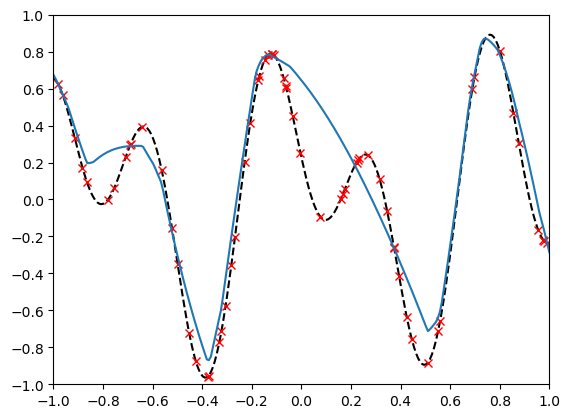

test loss: 0.143029


In [73]:
learning_rate = 0.01

batches_per_epoch = 1000
num_epochs = 10

loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.SGD(taylor_model.parameters(), lr=learning_rate)

writer = SummaryWriter("../experiments/graph_function/taylor/" + now.strftime("%Y%m%d-%H%M%S"))

training_loop(taylor_model, taylor_data, loss_fn, optimizer, num_epochs, batches_per_epoch)

writer.close()
del writer

# Fourier Series Features
These two cells are again nearly identical. This time the network takes in fourier features to learn the function faster. This time it is very clearly learning to approximate the function much faster. This can result in overfitting but I don't think that's a problem for this test. The number of fourier steps/features can be changed at the top of the first cell.

In [84]:
num_fourier_steps = 4
num_fourier_features = num_fourier_steps * 2
input_layer_size = num_fourier_features + 1
fourier_model = NeuralNetwork(input_layer_size)

fourier_data = TrainingData()

fourier_data.input_tensor_sample_batch = torch.zeros(num_samples, input_layer_size)
fourier_data.input_tensor_test_batch = torch.zeros(num_tests, input_layer_size)

def FillTensorBatchFourierSeries(input_tensor_batch, x_inputs):
    for tensor_index, input_tensor in enumerate(input_tensor_batch):
        # set x input value    
        input_tensor[0] = x_inputs[tensor_index].item()

        # calculate and set fourier features
        for fourier_step in range(0, num_fourier_steps):
            sin_fourier_feature_offset = fourier_step * 2 + 1
            cos_fourier_feature_offset = sin_fourier_feature_offset + 1

            input_tensor[sin_fourier_feature_offset] = np.sin((fourier_step + 1) * x_inputs[tensor_index]).item()
            input_tensor[cos_fourier_feature_offset] = np.cos((fourier_step + 1) * x_inputs[tensor_index]).item()

FillTensorBatchFourierSeries(fourier_data.input_tensor_sample_batch, sample_inputs)
FillTensorBatchFourierSeries(fourier_data.input_tensor_test_batch, test_inputs)

fourier_data.output_tensor_sample_batch = torch.from_numpy(np.reshape(sample_outputs, (-1, 1)))
fourier_data.output_tensor_test_batch = torch.from_numpy(np.reshape(test_outputs, (-1, 1)))

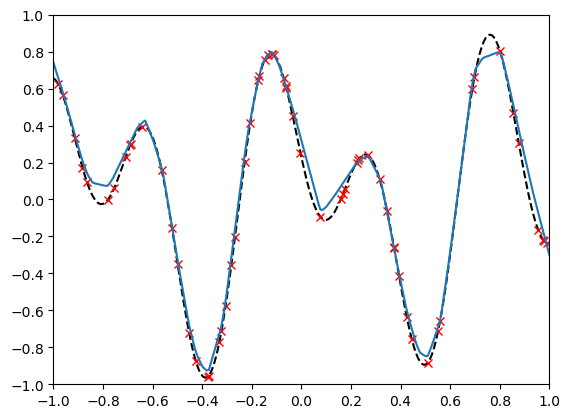

test loss: 0.039228


In [85]:
learning_rate = 0.01

batches_per_epoch = 1000
num_epochs = 10

loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.SGD(fourier_model.parameters(), lr=learning_rate)

now = datetime.datetime.now()

writer = SummaryWriter("../experiments/graph_function/fourier/" + now.strftime("%Y%m%d-%H%M%S"))

training_loop(fourier_model, fourier_data, loss_fn, optimizer, num_epochs, batches_per_epoch)

writer.close()
del writer

In [79]:
writer = SummaryWriter("../experiments/graph_function/fourier")

writer.add_graph(fourier_model.linear_relu_stack, fourier_data.input_tensor_sample_batch)

writer.close()
del writer